In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
from itertools import product

import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv("WAG_C_M.csv", sep=";", index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


## 1. Посмотрим на ряд

<AxesSubplot:xlabel='month'>

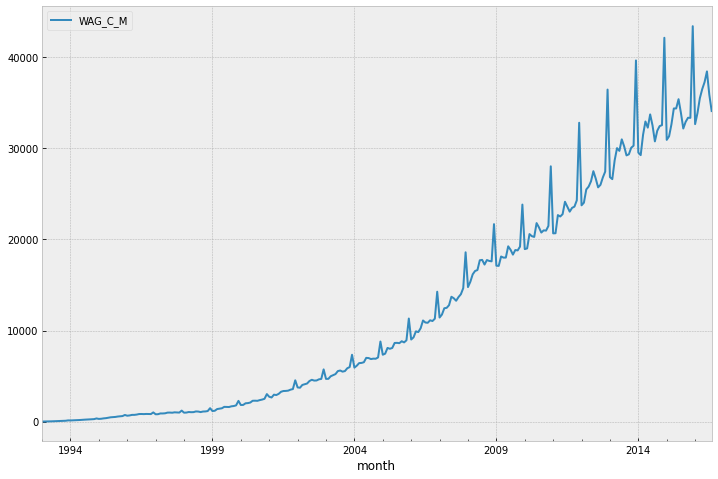

In [3]:
data.plot(figsize=(12,8))

Сразу видно, что ряд не является стационарным, во-первых, в ряде ярко выраженный тренд, во-вторых, присутствует сезонность, в-третьих, увеличивается дисперсия разброса данных 

In [4]:
result = adfuller(data.WAG_C_M)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.813411
p-value: 0.991850
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.573


Таким образом, тест дики-Фуллера ещё раз подтвердил, что ряд является стационарным

<Figure size 1440x720 with 0 Axes>

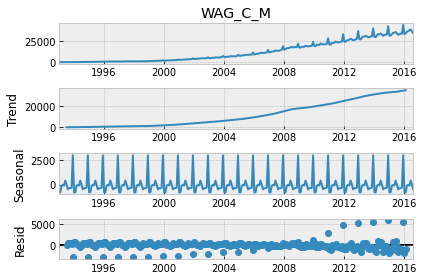

In [5]:
plt.figure(figsize=(20,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot();

## 2. Стабилизируем дисперсию

In [6]:
Сделаем преобразование Бокса-Кокса для стабилизации дисперсии

SyntaxError: invalid syntax (<ipython-input-6-9f8b7cbe676b>, line 1)

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


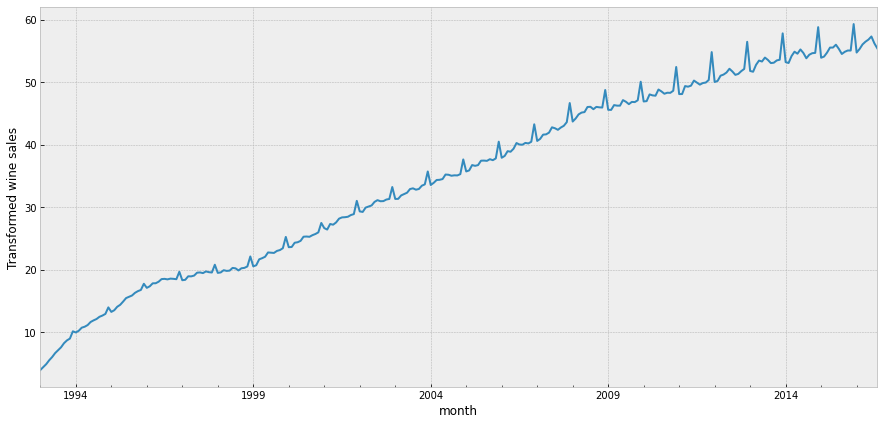

In [7]:
data['WAG_C_M'], lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

<Figure size 1440x720 with 0 Axes>

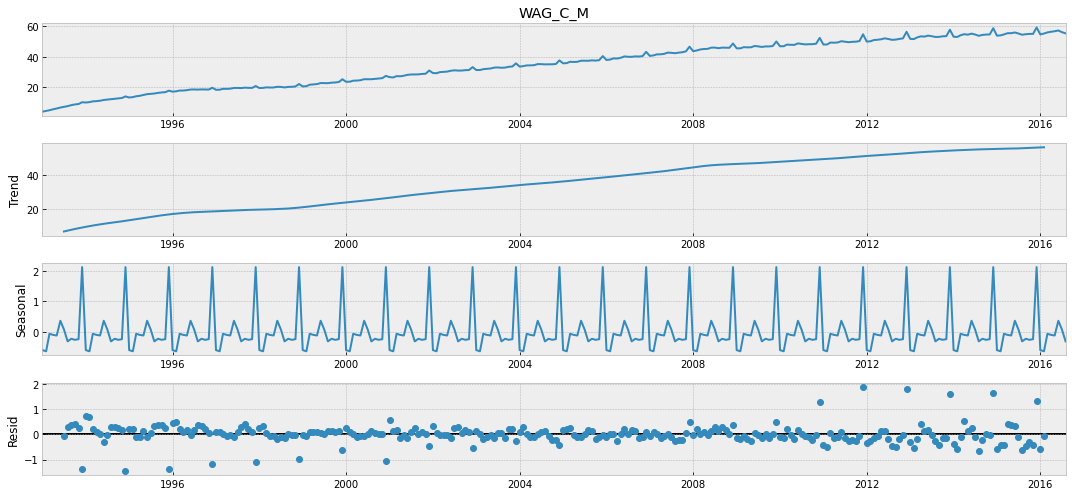

In [8]:
plt.figure(figsize=(20,10))
sm.tsa.seasonal_decompose(data.WAG_C_M).plot();

## 3. Выбор порядка дифференцирования

In [9]:
начнем с сезонного дифференцирования

SyntaxError: invalid syntax (<ipython-input-9-7ac2ea15aab0>, line 1)

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

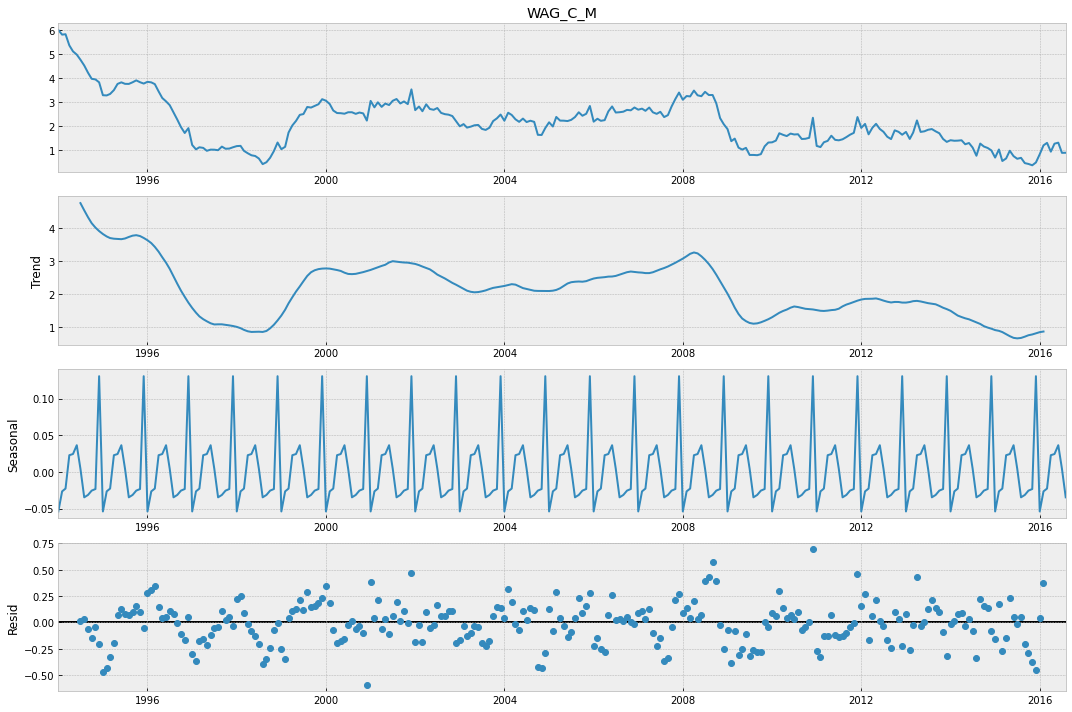

In [10]:
data['WAG_C_M'] = data.WAG_C_M - data.WAG_C_M.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M[12:])[1])

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

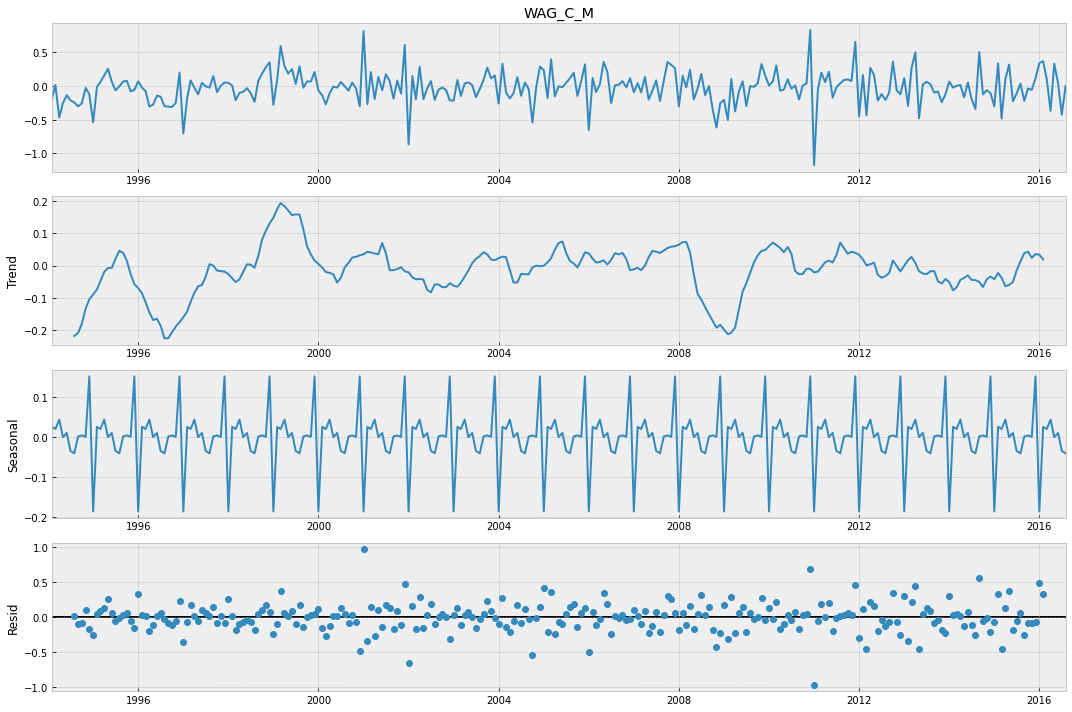

In [11]:
data['WAG_C_M'] = data.WAG_C_M - data.WAG_C_M.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.WAG_C_M[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M[13:])[1])

In [ ]:
избавились от тренда 

## 4. Выбор начальных приближений для p, q, P, Q

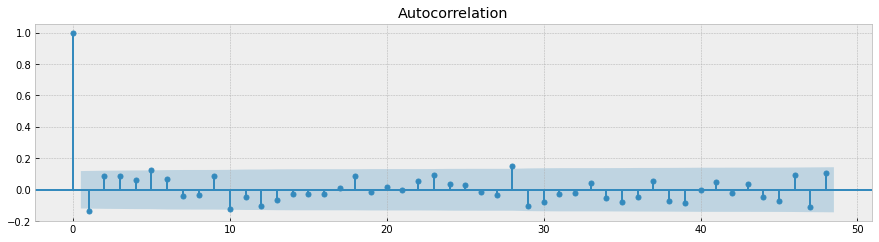

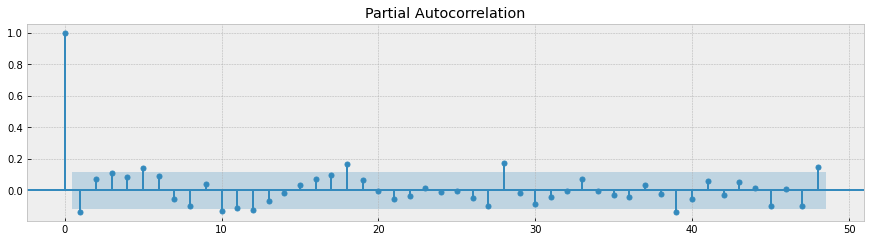

In [12]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_C_M[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_C_M[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [ ]:
Начальные приближения: Q=1, q=28, P=1, p=1

In [24]:
Q=1
q=1
P=1
p=1

In [25]:
ps = range(0, p+1)
d=1
qs = range(0, q+1)
Ps = range(0, P+1)
D=1
Qs = range(0, Q+1)

In [26]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [27]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 11.1 s, sys: 887 ms, total: 12 s
Wall time: 6.21 s


In [28]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head()) # информационный критерий Акаике

      parameters          aic
7   (0, 1, 1, 1)  3920.192198
15  (1, 1, 1, 1)  3922.190014
11  (1, 0, 1, 1)  3922.965949
6   (0, 1, 1, 0)  3939.103951
10  (1, 0, 1, 0)  3940.164639


In [29]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            WAG_C_M   No. Observations:                  284
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1956.096
Date:                            Tue, 09 Mar 2021   AIC                           3920.192
Time:                                    11:10:36   BIC                           3934.601
Sample:                                01-01-1993   HQIC                          3925.977
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2991      0.028    -10.531      0.000      -0.355      -0.243
ar.S.L12       0.9083      0.053   

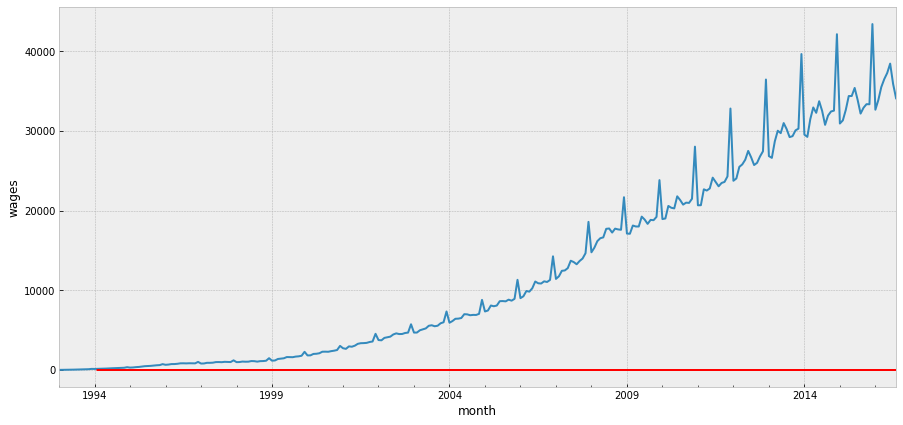

In [23]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('wages')
pylab.show()

In [22]:
data = pd.read_csv("WAG_C_M.csv", sep=";", index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
